In [9]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [10]:
import pandas as pd
from data_ingestion import ingest_data

In [11]:
fault_data_path = '../data/raw/fault_data.csv'
scada_data_path = '../data/raw/scada_data.csv'
status_data_path = '../data/raw/status_data.csv'

## Merge the input data

In [12]:
# get raw data
fault_df = ingest_data(fault_data_path)
scada_df = ingest_data(scada_data_path)
status_df = ingest_data(status_data_path)

In [13]:
# Convert data columns to datetime format
status_df['Time'] = pd.to_datetime(status_df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
scada_df['DateTime'] = pd.to_datetime(scada_df['DateTime'], format='%m/%d/%Y %H:%M', errors='coerce')
fault_df['DateTime'] = pd.to_datetime(fault_df['DateTime'], errors='coerce')

# Merge the data by Time or DateTime
merged_df = pd.merge(scada_df, status_df, left_on='DateTime', right_on='Time', how='left')
merged_df = pd.merge(merged_df, fault_df, on='DateTime', how='left')

# Drop the dulicate "Time" column and rename
merged_df = merged_df.drop(columns=['Time_y'])
merged_df.rename(columns={'Time_x': 'Timestamp'}, inplace=True)

# Store the merge dataframe to a CSV file in the data/processed directory
merged_df.to_csv('../data/processed/merge_data.csv', index=False)


## Explore Time Series Effects

In [14]:
import matplotlib.pyplot as plt

# Extracting time-based features for seasonal analysis
merged_df['Year'] = merged_df['DateTime'].dt.year
merged_df['Month'] = merged_df['DateTime'].dt.month
merged_df['Day'] = merged_df['DateTime'].dt.day
merged_df['Hour'] = merged_df['DateTime'].dt.hour
merged_df['DayOfWeek'] = merged_df['DateTime'].dt.dayofweek

### 1. Monthly Trend

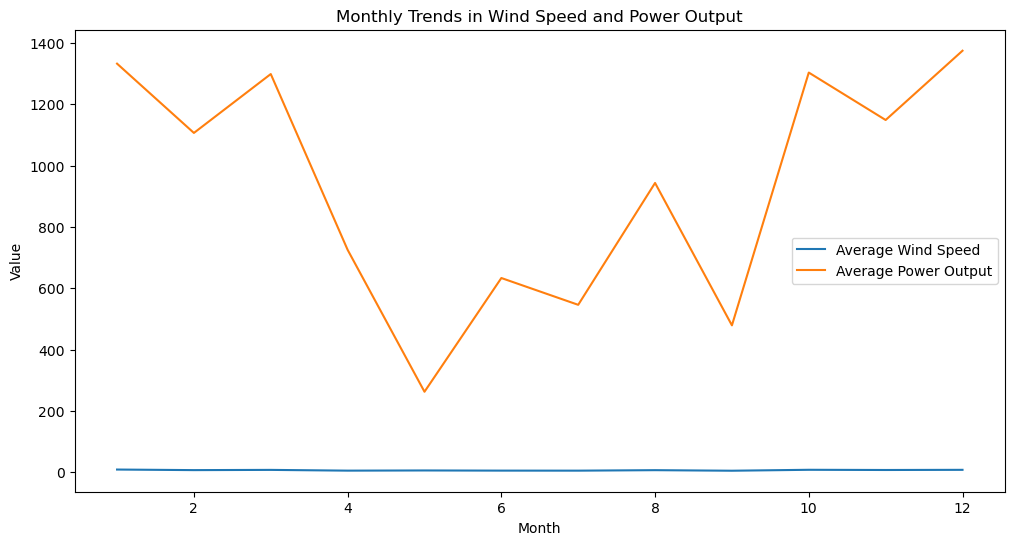

In [15]:
# Grouping by month to analyze seasonal effects on average wind speed and power
monthly_trends = merged_df.groupby('Month').agg({
    'WEC: ava. windspeed': 'mean',
    'WEC: ava. Power': 'mean'
}).reset_index()

# Plotting Monthly Trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends['Month'], monthly_trends['WEC: ava. windspeed'], label='Average Wind Speed')
plt.plot(monthly_trends['Month'], monthly_trends['WEC: ava. Power'], label='Average Power Output')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Monthly Trends in Wind Speed and Power Output')
plt.legend()
plt.show()

### 2. Weekly Trend

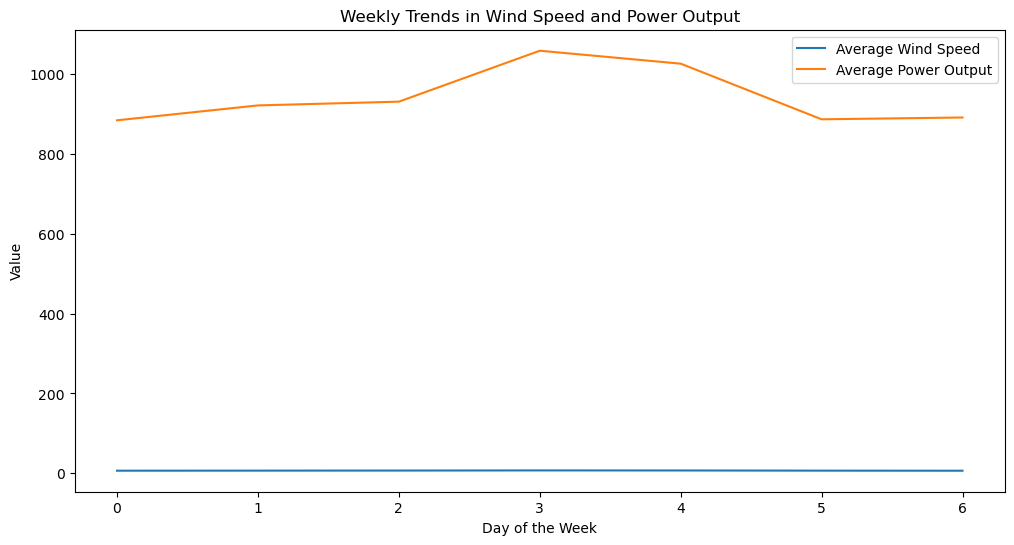

In [16]:
# Weekly Trends
weekly_trends = merged_df.groupby('DayOfWeek').agg({
    'WEC: ava. windspeed': 'mean',
    'WEC: ava. Power': 'mean'
}).reset_index()

# Plotting Weekly Trends
plt.figure(figsize=(12, 6))
plt.plot(weekly_trends['DayOfWeek'], weekly_trends['WEC: ava. windspeed'], label='Average Wind Speed')
plt.plot(weekly_trends['DayOfWeek'], weekly_trends['WEC: ava. Power'], label='Average Power Output')
plt.xlabel('Day of the Week')
plt.ylabel('Value')
plt.title('Weekly Trends in Wind Speed and Power Output')
plt.legend()
plt.show()